<h1> NLP Project </h1>
<h2 style ="color:blue"> Search Engine and Literature Clustering</h2>
<p>This notebook utilizes two major topics in natural language processing to tackle and answer questions related to COVID-19. The first one is: a <i>search engine</i> which allows the user to enter a query and fetches for them the most relevant papers related to that query (max 5). The other topic is <i>literature clustering</i> where PCA algorithm was used to reduce the dimension of the data, followed by K-means which was used to cluster the papers.</p>

In [20]:
# basic libraries
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
from tqdm import tqdm
import re #import the regular expression library
import string
import os
import json
import matplotlib.pyplot as plt 

# sklearn libraries used for tfidf and cosine similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import load_files

# nltk libraries for stop word and puncuation removal.
# nltk libraries for word lemmitization
import nltk
from nltk import pos_tag
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords #import the stopwords from the ntlk.corpus library
nltk.download('stopwords')
from nltk.tokenize import word_tokenize #import the word_tokenize method, which is used to turn sentences into words"
nltk.download('punkt')
from collections import Counter
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# !pip install scispacy scipy
# !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz
import en_core_sci_lg  
plt.style.use('ggplot')

from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<h4>STEP 1: DATA PREPROCESSING</h4>


<p> Before applying the NLP techniques on the data, data must be preprocessed, cleaned, structured,etc. In the following cell, the folder(s) containing the data in the json format are accessed. Each json file has, then, three majors information extracted from it:<br/>
 <ol>
     <li>The title of the paper</li>
     <li>The abstract of the paper</li>
     <li>The body/full text of the paper</li>
</ol>
These are then added to the list which will contain all the papers with those 3 features or attributes. The list is then converted to a dataframe which will be used later in this notebook.

In [3]:
FullPaper=[]#a list which will save all the papers 
directories = ["biorxiv_medrxiv"] #the folder name which contains the papers
for directory in directories: #for each of the folders carrying the json format of different research papers
    for file in tqdm(os.listdir(f"{directory}/{directory}/pdf_json")): #for every json file
        file_path=f"{directory}/{directory}/pdf_json/{file}" #set the file path to the file_path variable 
        paper = json.load(open(file_path,"rb")) #load the json version of the file
        title = paper['metadata']['title'] #set the title variable to the file's title
        try:
            abstract = paper['abstract']#set the abstract variable to the file's abstract
        except:
            abstarct=""   #set the abstract variable to the an empty string if the file does not have an abstract             
        full_text="" #create an empty string which will hold the body of the paper (file)    
        
        for text in paper['body_text']: #for every word in the body of the file
            full_text += (text['text'] +'\n') #concatenate the word to the variable full_text
        FullPaper.append([title,abstract,full_text]) #since the 3 variable: title, abstract, full_text, now have a value, a paper can be created and added to the FullPaper list
        
FullPaperDataframe=pd.DataFrame(FullPaper,columns=['title','abstract','full_text'])#create a dataframe which will hold all the papers

100%|███████████████████████████████████████████████████████████████████████████| 1342/1342 [01:08<00:00, 19.55it/s]


<h5>Data Cleaning</h5>
<p>In the below cell, each body text for each paper is stripped off stop words, punctuation, and is lemmatized. The <i>en_core_sci_lg</i> model was used as it works well on biomedical and scientific papers </p>
<h6 style = "color:green"> PROS Data Cleaning </h6>
<p>Data Cleaning is an essential step in producing high quality data to be further used. By removing stopwords, unnessary puncuations and lemmitization we are able to refine the data avaliable in the dataset to produce high quality results in our project.</p>
<p>We choose to use lemmitization instead of stemming as stemming removes only the suffixes of the word rather than search for its root in a dictionary which is done using lemmtization.</p>
<h6 style = "color:red"> CONS associated with data cleaning </h6>
<p> Some semantic meaning of the data may be lost during the cleaning process.</p>

In [4]:
full_text = FullPaperDataframe['full_text']

clean_text = [] #a list which will hold the clean paper text (after data processing)
dirty_text = []# a list which will hold the dirty paper text (before data processing)
# Intializing parser lemmtizer
lemmatizer = WordNetLemmatizer()

# Using the scispacy library to get the biomedical terms 
parser=en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

# extending and customizing the stopwords list (Since we found these words in the text before adding the our_stopwords list)
all_stopwords = stopwords.words('english')
# 'the','we','it','they',
our_stopwords=['copyright','https','et','al','preprint','preprints',
               'this','these','also','however','although','among','in','medrxiv',
                'biorxiv','license','without','fig','figure','doi','www','author','authors']
all_stopwords.extend(our_stopwords)

pattern = """!"#$%&'()*+,.:;<=>?@[\]^`{|}~"""

#  removing all stop words and extracting puctuations
for val in tqdm(full_text):
    val = val.lower()
    body_tokens = word_tokenize(val)
    paper_body_without_stopwords =  [token for token in body_tokens if not token in all_stopwords]#a list which will hold the tokens stripped off stop words and words that aren't pronouns
    dirty_paper_tokens = [token for token in body_tokens] #will hold the tokens as is
    clean_string = ' '.join(paper_body_without_stopwords) #convert the list into string
    clean_string = re.sub(rf"[{pattern}]", '', clean_string) #Strip punctuation from the text
    clean_string = re.sub(r'\b[a-zA-Z]\b', '', clean_string) # from single letters from the text
    clean_string = re.sub(r'^\d+\s|\s\d+\s|\s\d+$', '', clean_string) #remove digits that aren't associated with a word from the text
    clean_text.append(clean_string)
    dirty_string=' '.join(dirty_paper_tokens)#convert the list of the dirty tokens into a string
    dirty_text.append(dirty_string) #this list will be used later for analysis
lemmatized_text=[]    # a list which will carry the lemmatized text

# applying the parserer on the dataset
for val in tqdm(clean_text):
    lemmatized_string=[]
    words=val.split(' ')
    for word in words:
        if(len(word)>1):
            token = parser(word)
            lemm_token = lemmatizer.lemmatize(token.text)
            lemmatized_string.append(lemm_token)
    if(len(lemmatized_string)>0):
        lemmatized_text.append(lemmatized_string)
        
for i in range(len(lemmatized_text)):
    lemmatized_text[i]=" ".join(lemmatized_text[i])
    
print(lemmatized_text)

100%|█████████████████████████████████████████████████████████████████████████| 1342/1342 [1:54:33<00:00,  5.12s/it]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<h5> Corpus Word Count Graph Before Vs. After Data Cleaning </h5>

<p>To demonstrate how effective the data cleaning is, below is a bar chart comparing the corpus word count before and after the data cleaning.</p>

26548830
17344151


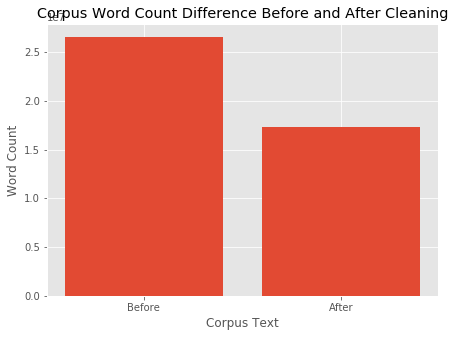

In [5]:
count1=0
count2 =0

for d in dirty_text: #get the word count in all the corpus before preprocessing
    count1 +=len(d)

for st in lemmatized_text:#get the word count in all the corpus after preprocessing
    count2+=len(st)
labels_x=["Before", "After"]
values = [count1, count2]
print(count1)
print(count2)
plt.figure(figsize=(7, 5))
plt.bar(labels_x, values)
plt.xlabel('Corpus Text')
plt.ylabel('Word Count')
plt.title('Corpus Word Count Difference Before and After Cleaning')
plt.show()

<h4>STEP 2: SEARCH ENGINE IMPLEMENTATION</h4>

<h5>TF-IDF</h5>
<p> After the data has been preprocessed, a TF-IDF matrix is to be created. This is a matrix which will hold the values of each word (bag of words of all the corpus) with respect to the document (paper).</p> 
<h6 style = "color:green"> PROS of using tf-idf</h6>
<p>tf-idf matrix considers the unique descriptives words in a corpus and gives them high values. On the contrary, it gives low values to reptitive words in the corpus. Hence, it helps to achieve accurate results for a search engine. </p>
<h6 style = "color:red"> CONS of using tf-idf</h6>
<p>tf-idf matrix does not account for semantics at all, unlike word embeddings, for example.</p>

In [7]:
#create a tf-idf matrix for the words above
v = TfidfVectorizer(min_df = 0.05,max_df = 0.8)
#For the above tf-idf vectorizer:
#The first parameter specifies that if a term appears in less than 5% of the docs, ignore it
#The second parameter, considers word that do not occur in more than 80% of the corpus
tfidf = v.fit_transform(lemmatized_text) #fit and transform the lemmatized texts which were previously cleaned.
#print(sorted(v.vocabulary_.items(), key=lambda x : x[1]))
print(tfidf.toarray())
print(tfidf.shape)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.02239898 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.04055696 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
(1342, 2375)


<h5>Cosine Similarity</h5>
<p> Cosine similarity is then utilized to get the documents which are closest to the query. The closer the cosine similairty value is to 1, the closer the document is to the query (The more likely it is going to be output). However, for this notebook, we choose to display the top 5 papers with cosine similarity greater than or equal <i>0.1</i>. This number was chosen after several trials to fetch the most relevant papers for different queries.</p>
<h6 style = "color:green"> PROS of using cosine similarity</h6>
<p>Cosine similarity is of a good use, as it can match related documents and queries quite well compared to euclidean distance. Euclidean distance can classify documents and queries as non-similar even if the distribution of terms is significantly alike</p>

In [8]:

#Next, the search engine will be implemented with the help of the tf-idf matrix created above and the cosine similarity
flag = False # a flag to indicate whether or not a result is found
pd.set_option('display.max_colwidth', -1)#to avoid dataframe column's data truncation
query = input("Enter your query: ") #get the query from the user
finalQuery="" #create an empty string
words = query.split(' ') #split the query on spaces
for word in words: #for each word in the query
    word = word.lower()
    if(word!=""): #if the word is not an empty string
        if (word=="coronaviruses"):#since lemmatize functions do not recognize the word coronaviruses as the plural of coronavirus, a conidition was created
            word ="coronavirus"
        lem_query = lemmatizer.lemmatize(word)#lemmatize the word
        finalQuery+=lem_query+" " #lemmatize the word and concat it to the string finalQuery
query = [finalQuery.strip()]# remove any trailing spaces from the query
query_tfidf = v.transform(query)
cosineSimilarities = cosine_similarity(query_tfidf, tfidf).flatten() #get the cosine similarity list 
#IF NO RESULT
print(cosineSimilarities)
countzero_in2 = np.count_nonzero(cosineSimilarities) #get the number of non zero values in cosine similarity
print(countzero_in2)
if (countzero_in2==0):#if all cosine similarities are 0 (no results)
    flag = True 

else:
    if (countzero_in2>=5):#if there are 5 or more cosine similarities that are greater than 0
        answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-5:] #get the top 5 indices with the highest cosine similarity
    else: #else if they are less than 5, get all of them
        answer_indicies = sorted(range(len(cosineSimilarities)), key=lambda i: cosineSimilarities[i])[-countzero_in2:] #get the top countzero_in2 indices with the highest cosine 
        

Enter your query: Disease models, including animal models for infection, disease and transmission
[0.         0.02176277 0.01242025 ... 0.12733774 0.03620335 0.00568204]
1315


[0.23581758156790616, 0.24175444821051353, 0.2571401811704759, 0.2573360580090854, 0.26376795744431764]
[21, 183, 939, 1221, 535]


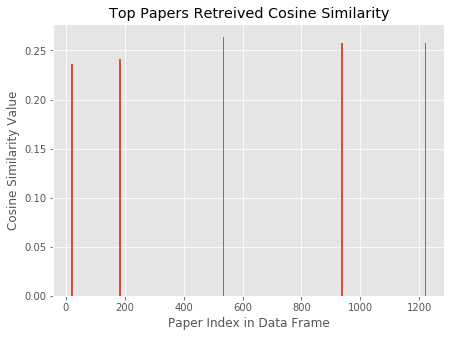

In [9]:
if (flag == False):
    values = [] # a list which will hold the cosine value of each paper outputted
    for i in answer_indicies:
        values.append(cosineSimilarities[i])
    print(values)
    print(answer_indicies)
    plt.figure(figsize=(7, 5))
    plt.bar(answer_indicies, values,width=6)
    plt.xlabel('Paper Index in Data Frame')
    plt.ylabel('Cosine Similarity Value')
    plt.title('Top Papers Retreived Cosine Similarity')
    plt.show()

<p>In the below cell, the code verifies whether or not the cosine similarity is >=0.1.  </p>

In [10]:
#loop on the top 5 indicies and display the title, abstract, and fulltext of the paper that was fetched from the search
if (flag == True):
    print("Sorry, no results")
else:
    counter =0
    for index in answer_indicies:
        if (cosineSimilarities[index]>=0.1): #get papers with cosine similarities greater than or equal 0.1
            display(FullPaperDataframe.iloc[[index]])
        else:
            counter = counter+1
    if (counter == len(cosineSimilarities)):
        print("Sorry, no results")


title  \
21  A spatial model of CoVID-19 transmission in England and Wales: early spread and peak timing   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               abstract  \
21  [{'text': 'An outbreak of a novel coronavirus, named CoVID-19, was first reported in China on 31 December 2019. As of 9 February 2020, cases have been reported in 25 countries, including probable cases of human-to-human transmission in England.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'We adapted an existing national-scale metapopulation model to capture the spread of CoVID-19 in England and Wales. We used 2011 census data to capture population sizes and population movement, together with parameter estimates from the current outbreak in China.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'We predict that a CoVID-19 outbreak will peak 126 to 147 days (~4 months) after the start of person-to-person transmission in England and Wales in the absence of controls, assuming biological parameters remain unchanged. Therefore, if person-to-person transmission persists from February, we predict the epidemic peak would occur in June. The starting location has minimal impact on peak timing, and model stochasticity varies peak timing by 10 days. Incorporating realistic parameter uncertainty leads to estimates of peak time ranging from 78 days to 241 days after person-to-person transmission has been established. Seasonal changes in transmission rate substantially impact the timing and size of the epidemic peak, as well as the total attack rate.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'We provide initial estimates of the potential course of CoVID-19 in England and Wales in the absence of control measures. These results can be refined with improved estimates of epidemiological parameters, and permit investigation of control measures and cost effectiveness analyses. Seasonal changes in transmission rate could shift the timing of the peak into winter months, which will have important implications 

title  \
183  Running Title: Global Biogeography of Disease Emergence Title In search for the hotspots of Disease X: A biogeographic approach to mapping the predictive risk of WHO's Blueprint Priority Diseases   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     abstract  \
183  [{'text': 'Anthropization of natural habitats including climate change along with overpopulation and global travel have been contributing to emerging infectious diseases outbreaks. The recent COVID-19 outbreak in Wuhan, highlights such threats to human health, social stability and global trade and economy. We used species distribution modelling and environmental data from satellite imagery to model Blueprint Priority Diseases occurrences. We constructed classical regression and Support Vector Machine models based on environmental predictor variables such as landscape, tree cover loss, climatic covariates. Models were evaluated and a weighed mean was used to map the predictive risk of disease emergence. We mapped the predictive risk for filovirus, Nipah, Rift Valley Fever and coronavirus diseases. Elevation, tree cover loss and climatic covariates were found to significant factors influencing disease emergence. We also showed the relevance of disease biogeography and in the identification potential hotspots for Disease X in regions in Uganda and China.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

title  \
939  A Note on COVID-19 Diagnosis Number Prediction Model in China   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          abstract  \
939  [{'text': 'Importance: To predict the diagnosed COVID-19 patients and the trend of the epidemic in China. It may give the public some scientific information to ease the fear of the epidemic. Objective: In December 2019, pneumonia infected with the novel coronavirus burst in Wuhan, China. We aimed to use a mathematical model to predict number of diagnosed patients in future to ease anxiety on the emergent situation. Design: According to all diagnosis number from WHO website and combining with the transmission mode of infectious diseases, the mathematical model was fitted to predict future trend of outbreak. Setting: Our model was based on the epidemic situation in China, which could provide referential significance for disease prediction in other countries, and provide clues for prevention and intervention of relevant health authorities.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

title  \
1221  Public Exposure to Live Animals, Behavioural Change, and Support in Containment Measures in response to COVID-19 Outbreak: a population-based cross sectional survey in China   

                                                                                                                                                                                                                                                                                                                                                                                                                              abstract  \
1221  [{'text': 'Word count (main text): 3489 : medRxiv preprint', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}, {'text': 'The public responded quickly to the outbreak, and reduced exposure to live animals, especially in Wuhan. With high public support in containment measures, better regulation of wet markets and healthy diets should be promoted.', 'cite_spans': [], 'ref_spans': [], 'section': 'Abstract'}]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

title  \
535  Comparison of alternative models of human movement and the spread of disease   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

<h4>STEP 4: LITERATURE CLUSTERING</h4>

<p>The second part of this notebook attempts to before K-Means clustering on the papers, such that each group of papers related together via certain keywords are grouped together.</p> 
<h6 style = "color:green"> PROS of using K-means</h6>
<p> The pros of using K-means is that many packages provide its functionality and it is easy to implement.</p>
<h6 style = "color:red"> CONS of using K-means</h6>
<p> When clustering a new paper, the distance between that paper and every other paper should be computed, which is time consuming. Besides, the number of clusters which are to be chosen from the optimum cluster number, must be chosen.</p>

<h5>Dimensionality Reduction</h5>
<p>At this stage, we have lots of features/words in the TIF-IDF matrix. However, to allow the K-means to perform better, dimensionality reduction is needed. Therefore, the PCA algorithm is chosen, as it is known that it performs well with K-Means </p>

In [11]:
from sklearn.decomposition import PCA #import PCA which will be used to reduce the dimensions of the dataset

pca = PCA(n_components=0.90,random_state=30)#keep 90% of the variance, and start random centroid @ 30
tf_idf_norm_kmeans= pca.fit_transform(tfidf.toarray())

<h5>Elbow testing </h5>
<p>In order to determine how many clusters are needed for the K-means. A graph is plotted, the point at which the elbow forms is then searched. That value should be used as the number of clusters. </p>

100%|███████████████████████████████████████████████████████████████████████████████| 12/12 [00:16<00:00,  1.36s/it]


<Figure size 1440x1440 with 0 Axes>

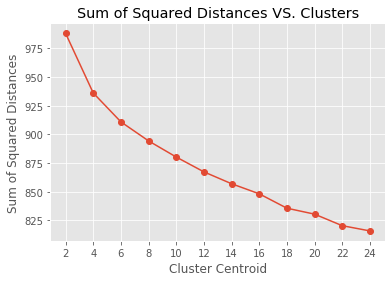

<Figure size 1440x1440 with 0 Axes>

In [12]:
from sklearn.cluster import KMeans #import kmeans which will be used to cluster the data


max_number_of_clusters = 25 #clusters can range from 2-max_number_of_clusters
max_number_of_clusters = max_number_of_clusters+1 # since the range method is exclusive, a 1 should be added.
Ks = range(2, max_number_of_clusters, 2) #Hold the range of clusters k (from 2-max_number_of_clusters)
    
sum_of_squared_distances = [] #a list which will carry the sum of squared distances at each k
for k in tqdm(Ks):
    sum_of_squared_distances.append(KMeans(n_clusters=k,random_state=30).fit(tf_idf_norm_kmeans).inertia_)#calculate the sum of squared distance for each k.
        
  #plot the elbow graph      
f, ax = plt.subplots(1, 1)
ax.plot(Ks, sum_of_squared_distances, marker='o')
ax.set_xlabel('Cluster Centroid')
ax.set_xticks(Ks)
ax.set_xticklabels(Ks)
ax.set_ylabel('Sum of Squared Distances')
ax.set_title('Sum of Squared Distances VS. Clusters')
plt.figure(figsize=(20,20))

<h5>Elbow Graph Analysis </h5>
<p>As exhibited in the graph above the elbow forms at k = 15, as the graph starts to level off</p>
<h1 style ="color:red"> CHANGE K WHEN YOU RUN ALL THE DATASET. The above is for 1934 papers</h1>

<h5> K-Means clustering</h5>
<p>Now that the number of clusters is known, k-means can be performed as shown in the cell below </p>

In [13]:
clusters = KMeans(n_clusters=15,random_state=30).fit_predict(tf_idf_norm_kmeans) #from the elbow graph we get the n_clusters
df =FullPaperDataframe.copy(deep=True)  #create a new df which will hold the papers attribute along with the cluster number


<p>In the below cell, the cluster to which the paper belongs is added to the dataframe</p>

In [14]:
df['clusters'] = clusters
#save the dataframe
df.to_csv('clusters_df.csv')
df.head() #display the head

title  \
0  The RNA pseudoknots in foot-and-mouth disease virus are dispensable for genome replication but essential for the production of infectious virus. 2 3   
1  Analysis Title: Regaining perspective on SARS-CoV-2 molecular tracing and its implications                                                             
2  Healthcare-resource-adjusted vulnerabilities towards the 2019-nCoV epidemic across China                                                               
3  CHEER: hierarCHical taxonomic classification for viral mEtagEnomic data via deep leaRning                                                              
4  Real-time, MinION-based, amplicon sequencing for lineage typing of infectious bronchitis virus from upper respiratory samples                          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

<h5>Visualization of clusters</h5>

To get a better sense of the clusters resulting from applying kmeans, we'll plot the clusters.

After applying PCA to the cleaned data, we still have too many dimensions to be able to visualize the clusters. This is why further dimensionality reduction is applied on this highly dimesnional data. We chose to use the TSNE technique on top of PCA.

In [ ]:
tsne = TSNE(random_state=30).fit_transform(tf_idf_norm_kmeans)
    
f, ax = plt.subplots(1, figsize=(9, 6))
    
cmap = {0: 'lime', 1: 'red', 2: 'blue', 3: 'green', 4: 'yellow', 5: 'orange', 6: 'pink', 7: 'purple', 8: 'brown', 
        9: 'black', 10: 'lightgreen', 11: 'lightblue', 12: 'deepskyblue', 13: 'violet', 14: 'indigo'}

for c in np.unique(clusters):
    ix = np.where(clusters == c)
    ax.scatter(tsne[ix, 0], tsne[ix, 1], c=cmap[c])
        
ax.set_title('TSNE Cluster Plot')

The previous plot gives us more insight into how the papers are clustered/grouped. The algorithms used may help us find connections amongst different papers that may have been initially unapparent to us. This can help in the extraction of important information from the papers and advancing research.

Next we apply topic modeling to find the most significant keywords that distinguish the clusters. This will allow us to obtain more meaning about the topics/themes of the different clusters.

<h1>Topic Modeling</h1> 
<p>Group the documnents according to their cluster</p>

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

clean_text = np.array(lemmatized_text)

#grouped_docs is a dictionary that holds the docs indices in a cluster eg. {0: [5,20,31], 1: [7,8,11]...}
grouped_docs = df.groupby('cluster').indices

<p>Topic modeling for the set documents within each cluster </p>

In [ ]:
for i in range(0,20):
    
    # get the tf-idf matrix for the documents within this cluster
    v = TfidfVectorizer(sublinear_tf = True, min_df = 0.05,max_df = 0.8)
    current_tf_idf = v.fit_transform(clean_text[grouped_docs[i]])
    feature_names = v.get_feature_names()
    
    # get the top words for 2 topics within each cluster
    lda_model = LatentDirichletAllocation(n_components= 2, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=30)
    lda_model.fit(current_tf_idf)
    lda_model.transform(current_tf_idf)
    
    n_top_words = 10
    print ("cluster {}: ".format(i))
    
    for topic_idx, topic in enumerate(lda_model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]+","
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message[:-1])
    print()